# INR vs USD currency predictor using  Time-Series 
We are going to predict the possible value of INR compared to USD by performing Time-Series predictoin in Tensorflow


### 1. Aim
The aim is to create a model for predicting INR value agains USD by performing Time-Series-Prediction using last 8 years Dataset using Neural Networks


### 2. Setup

In [1]:
#check the version on TF (make sure it's 2.0+)
import tensorflow as tf
print(tf.__version__)

2.2.0


In [0]:
#importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive



### 3.1 Fetching dataset
We have 2 DATSETS available, 
  1. inr-usd.csv:  ( having business days currency value from 15-04-2013 to 12-05-2020 )
  2. inr-usd2.csv:  ( having weekly currency value from 24-04-2005 to 10-05-2020 )



In [52]:
df1=pd.read_csv('/content/drive/My Drive/INR-USD-Prediction/dataset/usd-inr.csv')
print(df1.head())
print(df1.tail())




       Date   Price    Open    High     Low Volume    Chg%
0  13/04/10  44.545  44.345  44.705  44.295      0   0.13%
1  14/04/10  44.215  44.455  44.455  44.175      0  -0.74%
2  15/04/10  44.345  44.165  44.515  44.075      0   0.29%
3  16/04/10  44.275  44.285  44.605  44.215      0  -0.16%
4  19/04/10  44.735  44.235  44.755  44.195      0   1.04%
          Date   Price    Open    High     Low Volume    Chg%
2627  07/05/20  75.794  76.100  76.145  75.773  0.48K  -0.41%
2628  08/05/20  75.535  75.588  75.645  75.262  3.32K  -0.34%
2629  11/05/20  75.888  75.535  75.925  75.450  5.78K   0.47%
2630  12/05/20  75.062  75.945  75.967  75.049  4.05K  -1.09%
2631  13/05/20  75.268  75.275  75.507  75.053  3.70K   0.27%


In [53]:
print('Shape',df1.shape,'\n____________\n')
print(df1.info())

Shape (2632, 7) 
____________

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2632 entries, 0 to 2631
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2632 non-null   object 
 1   Price   2632 non-null   float64
 2   Open    2632 non-null   float64
 3   High    2632 non-null   float64
 4   Low     2632 non-null   float64
 5   Volume  2632 non-null   object 
 6   Chg%    2632 non-null   object 
dtypes: float64(4), object(3)
memory usage: 144.1+ KB
None


In [54]:
df2=pd.read_csv('/content/drive/My Drive/INR-USD-Prediction/dataset/usd-inr2.csv')
print(df2.head())
print(df2.tail())


       Date   Price    Open    High     Low  Volume    Chg%
0  17/04/05  43.660  43.710  43.850  43.630       0  -0.25%
1  24/04/05  43.430  43.640  43.821  43.430       0  -0.53%
2  01/05/05  43.455  43.605  43.635  43.285       0   0.06%
3  08/05/05  43.430  43.330  43.560  43.160       0  -0.06%
4  15/05/05  43.480  43.350  43.650  43.350       0   0.12%
         Date   Price    Open    High     Low  Volume    Chg%
782  12/04/20  76.550  75.879  76.914  75.879       0   0.88%
783  19/04/20  76.270  76.550  77.010  75.817       0  -0.37%
784  26/04/20  75.749  76.270  76.449  74.909       0  -0.68%
785  03/05/20  75.535  75.750  76.145  75.262       0  -0.28%
786  10/05/20  75.321  75.535  75.962  75.049       0  -0.28%


In [55]:
print('Shape',df1.shape,'\n____________\n')
print(df1.info())

Shape (2632, 7) 
____________

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2632 entries, 0 to 2631
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2632 non-null   object 
 1   Price   2632 non-null   float64
 2   Open    2632 non-null   float64
 3   High    2632 non-null   float64
 4   Low     2632 non-null   float64
 5   Volume  2632 non-null   object 
 6   Chg%    2632 non-null   object 
dtypes: float64(4), object(3)
memory usage: 144.1+ KB
None


Since we only need the time stamp and the price, hence we'll remove the rest of the columns except Chg% for now.

In [56]:
df1=df1.drop(['Open','High','Low','Volume','Chg%'],axis=1)
df2=df2.drop(['Open','High','Low','Volume','Chg%'],axis=1)
print(df1.head(),'\n\n')
print(df2.head())

       Date   Price
0  13/04/10  44.545
1  14/04/10  44.215
2  15/04/10  44.345
3  16/04/10  44.275
4  19/04/10  44.735 


       Date   Price
0  17/04/05  43.660
1  24/04/05  43.430
2  01/05/05  43.455
3  08/05/05  43.430
4  15/05/05  43.480


### 3.2 Feature Extraction
Since we have to plot our data, we need our values in the form of Vector/Array. Hence the feature extraction is necessary to get the desired format of dataset.

DF1 (the first dataset)

In [57]:
 #creating varibles 'step' and 'time_step'
days=len(df1.Date)
time_step=[]
price=[]
for i in range(days):
  time_step.append(i)
  price.append(df1['Price'][i])

#since the data we've is in opposite order 
series1=np.array(price)
time1=np.array(time_step)

# days: contain total number of days 
# time: contain the sequence 0 to 1846 
# series: contains the PRICE column values
print('days: ',days)
print('time1-sample: ',time1[:10])
print('series1-sample: ',series1[:10])


days:  2632
time1-sample:  [0 1 2 3 4 5 6 7 8 9]
series1-sample:  [44.545 44.215 44.345 44.275 44.735 44.515 44.555 44.535 44.315 44.395]


DF2 (the second dataset)

In [58]:
#creating varibles 'step' and 'time_step'
weeks=len(df2.Date)
time_step=[]
price=[]
for i in range(weeks):
  time_step.append(i)
  price.append(df2['Price'][i])

#since the data we've is in opposite order 
series2=np.array(price)
time2=np.array(time_step)

# days: contain total number of days 
# time: contain the sequence 0 to 1846 
# series: contains the PRICE column values
print('weeks: ',weeks)
print('time1-sample: ',time2[:10])
print('series2-sample: ',series2[:10])

weeks:  787
time1-sample:  [0 1 2 3 4 5 6 7 8 9]
series2-sample:  [43.66  43.43  43.455 43.43  43.48  43.505 43.595 43.51  43.515 43.515]


### 3.2 Plotting Dataset
As we've the data in desired format i.e with timestamp and the values, we can plot the time-series

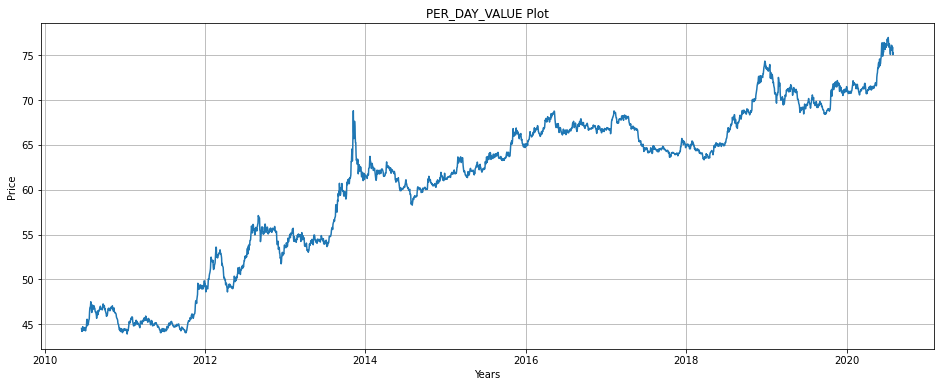

In [0]:
plt.figure(figsize=(16, 6))
plt.plot(2010+((120+time1)/(365-105)),series1)

# The 'time1' variable has the total number of DAYS
# Since the time-series starts from the month of April, hence adding 120 (days) == (3 months), so that our graph plots properly.
# Now, dividing the 'time1' by  365-105: was necessary as the dataset have the value for 5 working days per week, hence we've to remove 2 days per week.
# total week = 52.17 in a year
# total SAT_SUN = 2*52.14 = 104 
# hence our 1 year(365 days) plot is actuaually (365-104 days) plot
# Now the value recieved is 0..1..2...10  (but the year starts from 2010) hence adding 2010 finally!

plt.ylabel('Price')
plt.xlabel('Years')
plt.title('PER_DAY_VALUE Plot')

plt.grid(True,linestyle='-')

plt.show()

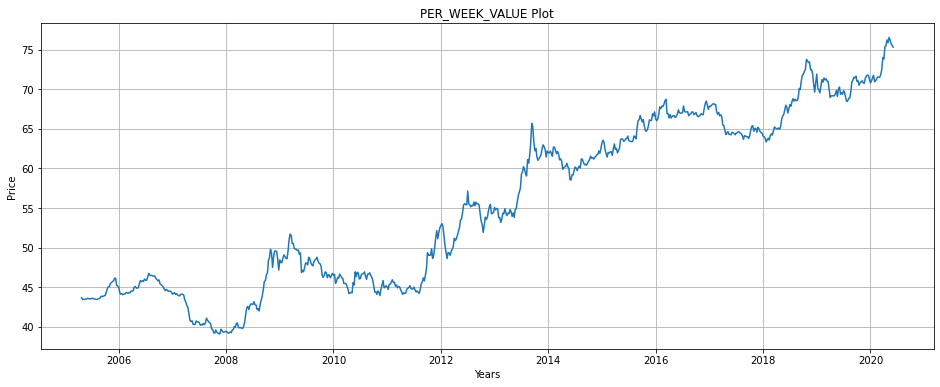

In [0]:
plt.figure(figsize=(16, 6))
plt.plot(2005+((16+time2)/52),series2)

# The 'time2' variable has the total number of WEEKS
# Since the time-series starts from the month of April, hence adding 12 (WEEKS) == (3 MONTHS), so that our graph plots properly. 
# And dividing by 52 weeks per year till now.
# Now the value recieved is 0..1..2...10  (but the year starts from 2010) hence adding 2010 finally!

plt.ylabel('Price')
plt.xlabel('Years')
plt.title('PER_WEEK_VALUE Plot')

plt.grid(True)

plt.show()

Comparing both the graphs we can see that the PER_DAY_VALUE graph is denser than the PER_WEEK_WEEK one. 

So let's WORK on the Time-Series for the PER_DAY_VALUE graph

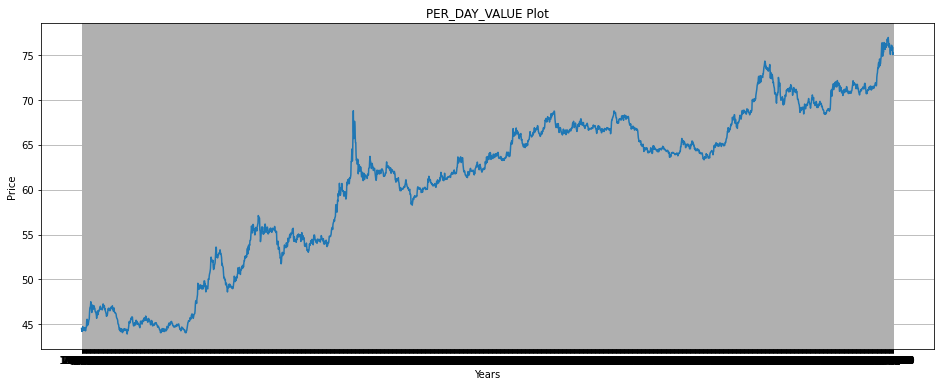

In [0]:
plt.figure(figsize=(16, 6))
plt.plot(df1.Date,series1)

plt.ylabel('Price')
plt.xlabel('Years')
plt.title('PER_DAY_VALUE Plot')
plt.grid(True)
plt.show()

### 4. Preprocessing 
Splitting up the dataset into _TRAIN_ and _VALIDATE_ ,

 Creating the _WINDOW_ for fix input size 

In [59]:
#Since the dataset is 2632 splitting into 2000-632
split_time = 2000
time_train = time1[:split_time]
x_train = series1[:split_time]
time_valid = time1[split_time:]
x_valid = series1[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 500

x_train.shape,x_valid.shape


((2000,), (632,))

In [60]:
print(df1['Date'][2000],df1['Date'][2631])

12/12/17 13/05/20


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1 , shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1 ))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [63]:

tf.random.set_seed(31)
np.random.seed(31)
window_size = 30
batch_size = 32
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2000,)


### 5. Building Model

In [64]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 32)          192       
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          24832     
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense_3 (Dense)              (None, None, 30)          1950      
_________________________________________________________________
dense_4 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_5 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda_1 (Lambda)            (None, None, 1)          

In [0]:

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)


### 6. Training the model

In [66]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
62/62 [==============================] - 1s 19ms/step - loss: 11.4914 - mae: 11.9726 - lr: 1.0000e-08
Epoch 2/100
62/62 [==============================] - 1s 19ms/step - loss: 11.2683 - mae: 11.7493 - lr: 1.1220e-08
Epoch 3/100
62/62 [==============================] - 1s 19ms/step - loss: 10.9590 - mae: 11.4413 - lr: 1.2589e-08
Epoch 4/100
62/62 [==============================] - 1s 19ms/step - loss: 10.6737 - mae: 11.1558 - lr: 1.4125e-08
Epoch 5/100
62/62 [==============================] - 1s 19ms/step - loss: 10.2946 - mae: 10.7757 - lr: 1.5849e-08
Epoch 6/100
62/62 [==============================] - 1s 19ms/step - loss: 9.9329 - mae: 10.4144 - lr: 1.7783e-08
Epoch 7/100
62/62 [==============================] - 1s 19ms/step - loss: 9.0993 - mae: 9.5749 - lr: 1.9953e-08
Epoch 8/100
62/62 [==============================] - 1s 19ms/step - loss: 9.1674 - mae: 9.6467 - lr: 2.2387e-08
Epoch 9/100
62/62 [==============================] - 1s 19ms/step - loss: 8.6307 - mae: 9.109

(1e-08, 0.0001, 0.0, 60.0)

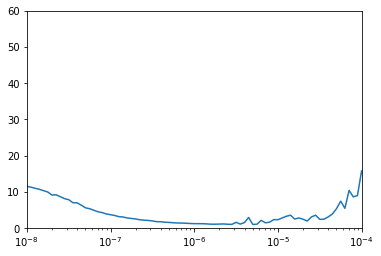

In [67]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [68]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=32, batch_size=44, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),

  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.8)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
45/45 [==============================] - 1s 21ms/step - loss: 6.4238 - mae: 6.8960
Epoch 2/150
45/45 [==============================] - 1s 20ms/step - loss: 2.3384 - mae: 2.7950
Epoch 3/150
45/45 [==============================] - 1s 20ms/step - loss: 2.6775 - mae: 3.1435
Epoch 4/150
45/45 [==============================] - 1s 20ms/step - loss: 1.9462 - mae: 2.4006
Epoch 5/150
45/45 [==============================] - 1s 21ms/step - loss: 1.4673 - mae: 1.9168
Epoch 6/150
45/45 [==============================] - 1s 21ms/step - loss: 1.2794 - mae: 1.7271
Epoch 7/150
45/45 [==============================] - 1s 21ms/step - loss: 1.2277 - mae: 1.6810
Epoch 8/150
45/45 [==============================] - 1s 21ms/step - loss: 1.1119 - mae: 1.5567
Epoch 9/150
45/45 [==============================] - 1s 21ms/step - loss: 1.0956 - mae: 1.5396
Epoch 10/150
45/45 [==============================] - 1s 20ms/step - loss: 1.0302 - mae: 1.4681
Epoch 11/150
45/45 [=============================

In [0]:
rnn_forecast = model_forecast(model, series1[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

 Got the below results with following values of the parameter:

1.  window_size = 60
2. batch_size = 100
3. learning_rate = 1e-5
4. shuffle_buffer_size = 500
5. momentum = 0.9

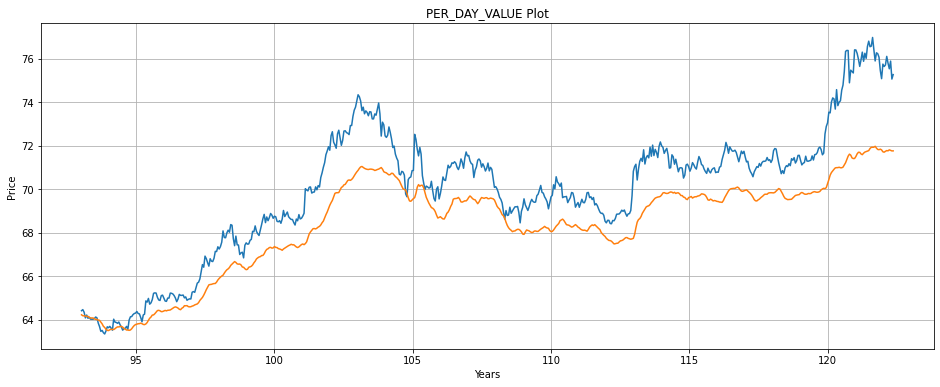

In [0]:
plt.figure(figsize=(16, 6))
plt.plot(time_valid,x_valid)
plt.plot(time_valid,rnn_forecast)
plt.ylabel('Price')
plt.xlabel('Years')
plt.title('PER_DAY_VALUE Plot')

plt.grid(True,linestyle='-')

plt.show()


MAE recieved = 1.86

Clearly we can see the  difference between the in the original and the predictie graph lines, let's try _tweaking_ the parameters a little.

______________________________________________________________________________

 Got the below results with following values of the parameter:

1.  window_size = 30
2. batch_size = 32
3. learning_rate = 1e-5
4. shuffle_buffer_size = 500
5. momentum = 0.8

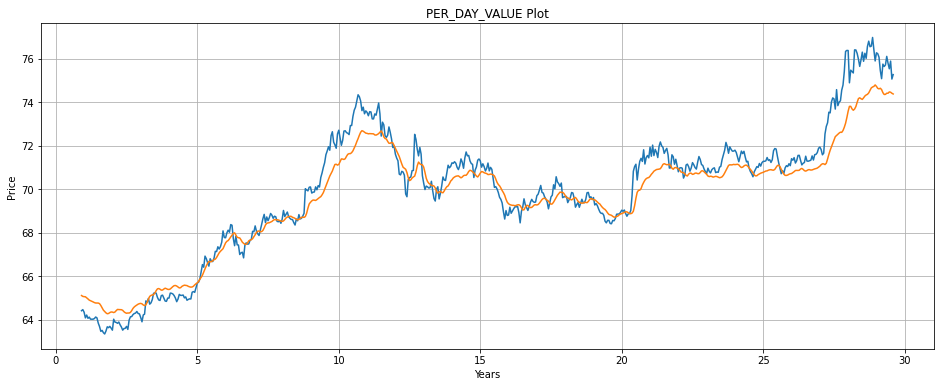

In [0]:
plt.figure(figsize=(16, 6))
plt.plot(-90+(time_valid/(30-8)),x_valid)
plt.plot(-90+(time_valid/(30-8)),rnn_forecast)
plt.ylabel('Price')
plt.xlabel('Years')
plt.title('PER_DAY_VALUE Plot')

plt.grid(True,linestyle='-')

plt.show()




MAE recieved = 0.6

We can see the predictie graph lines have now come closer as a result of reduced momentum and reduced buffer size and window size, which has yielded better results.

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.60091454

In [0]:
print(len(rnn_forecast))
print(rnn_forecast)


632
[65.10747  65.0674   65.05583  65.0512   65.004036 64.95153  64.89658
 64.87042  64.8396   64.81442  64.783485 64.76409  64.76549  64.76185
 64.734726 64.650215 64.53876  64.43517  64.36916  64.31039  64.27136
 64.28221  64.32374  64.35134  64.346855 64.324486 64.350296 64.41668
 64.46927  64.461754 64.46003  64.456024 64.4267   64.362625 64.31813
 64.2931   64.3046   64.30223  64.332184 64.41332  64.51581  64.58352
 64.63104  64.671455 64.711    64.73421  64.74682  64.725815 64.67321
 64.646515 64.67862  64.79624  64.94054  65.06835  65.1124   65.13552
 65.14586  65.22537  65.33017  65.41296  65.42897  65.399734 65.35507
 65.36051  65.40733  65.44553  65.422264 65.3922   65.38571  65.4089
 65.46232  65.51918  65.562004 65.56908  65.54483  65.4989   65.45702
 65.46686  65.526794 65.56038  65.58418  65.574135 65.56466  65.53056
 65.507545 65.49382  65.50136  65.53461  65.597725 65.65063  65.68987
 65.760185 65.85929  65.94477  66.04353  66.19127  66.33299  66.46987
 66.58923  66.674

<Figure size 432x288 with 0 Axes>

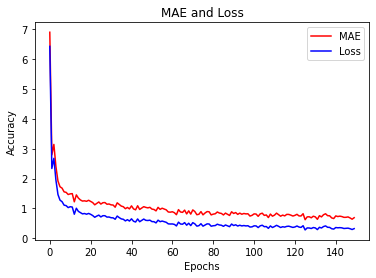

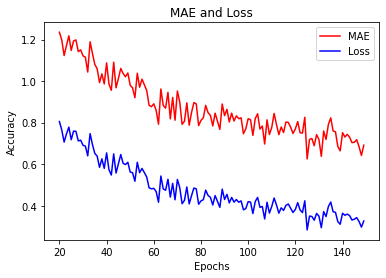

<Figure size 432x288 with 0 Axes>

In [73]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[20:]
mae_zoom = mae[20:]
loss_zoom = loss[20:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

### Saving the model

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


Loading the model 

In [0]:
!pip install h5py

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
loaded_model.summary()

Loaded model from disk
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 60)          360       
_________________________________________________________________
lstm (LSTM)                  (None, None, 60)          29040     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1830      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (Non